# 尋找潛在捐助者(Finding Donors for CharityML)

***
>### 專案介紹：
CharityML 是一家虛構的慈善組織，位於矽谷的中心地帶，旨在為渴望學習機器學習的人們提供財務支持。在向社區居民發送了近 32,000 封信之後，CharityML 確定他們收到的每一筆捐款都來自每年收入超過 5 萬美元的人。為了擴大他們潛在的捐贈者基礎，CharityML 已決定向加州居民發送信件，但僅向最有可能捐贈給慈善機構的人發信。加州擁有將近 1,500 萬名工作者，請幫他們構建算法，以便最好地識別潛在的捐贈者，並降低發送郵件的間接成本。因此，**目標是評估和優化幾個不同的機器學習模型，以確定哪種算法將提供最高的捐贈收益，同時還減少發送的信件總數。**

>### 方法概述：
Yoshua Bengio 和 Ian Goodfellow 等人(2016)合著的 [DeepLearning](http://www.deeplearningbook.org/contents/guidelines.html) 一書中提到，一個優秀的機器學習實踐者需要知道如何針對應用選擇一個合適的算法以及對其進行評估，再根據實驗反饋改進機器學習系統。因此要成功應用機器學習技術，我們需要從一個簡單的模型開始，之後轉向更複雜的算法。作者建議 4 個步驟如下：

>    1.根據目標選擇合適的效能指標。模型的好壞將由此指標來評估及優化。

>    2.快速建立一個完整的建模流程。並能夠評估所選定的效能指標。

>    3.評估模型，並確定效能瓶頸。檢查哪個部分的效能不如預期，以及是否因為過擬合、欠擬合，或者數據缺少造成。

>    4.根據觀察反复地進行增量式的改變，如收集新數據、調整參數或改進算法。

>    接者將由這 4 個步驟進行

## 目錄

* [1.資料探索](#1.-資料探索)


* [2. 模型建立](#2.-模型建立)
    * [2.1 資料準備](#2.1-資料準備)
    * [2.2 模型訓練](#2.2-模型訓練)
    * [2.3 模型評估](#2.3-模型評估)
 
 
* [3. 改善資料質量](#3.-改善資料質量)
    *  [3.1 探索性資料分析](#3.1-探索性資料分析)
    *  [3.2 多變量分析](#3.2-多變量分析)
    *  [3.3 資料預處理](#3.3-資料預處理)
    *  [3.4 資料評估](#3.4-資料評估)  
    
    
* [4. 模型優化](#4.-模型優化)  
    * [4.1 GradientBoosting 參數調整](#4.1-GradientBoosting-參數調整)
    * [4.2 模型評估](#4.2-模型評估)
    * [4.3 特徵重要性](#4.3-特徵重要性)
    
    
* [5. 結論](#5.-結論)


* [6. 參考資料](#6.-參考資料)

In [1]:
import warnings
warnings.filterwarnings('ignore')

#資料整理相關
import numpy as np
import pandas as pd
from time import time

#統計相關
from scipy import stats
from scipy.stats import norm

#模型預處理相關
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

#模型選擇&評估相關
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve,validation_curve 
from sklearn.metrics import fbeta_score , accuracy_score,roc_auc_score,make_scorer

#視覺化相關
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tools as tl
#模型相關
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV 

# 1. 資料探索

"資料的品質和特徵的選取決定了機器學習模型的上限，改進模型只是在逼近這個上限。"這句話到底是誰先開始說的呀?反正我是信了。
本節中會透過一些簡單的探索來確認我們擁有那些資料、資料的品質如何

In [2]:
#資料開箱!
data = pd.read_csv("census.csv")
data.head(n=1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


**變數的輪廓:**
* age: 年齡,連續型變數
* workclass: 工作類型(私人,地方政府..)
* education_level: 教育程度(學士,教授學校,11年級..)
* education-num: 完成的教育年數,連續型變數
* marital-status: 婚姻狀況(已婚,離婚,未婚,分居..) 
* occupation: 職業類型(技術支援,工藝修復,其他服務,銷售..)
* relationship: 家庭關係 (丈夫,太太,未結婚..)
* race: 種族(白人,亞太..)
* sex: 性別(女性,男性)
* capital-gain: 資本收益,連續型變數
* capital-loss: 資本損失,連續型變數
* hours-per-week: 週工時,連續型變數
* native-country: 祖國(美國,柬埔寨,英格蘭,波多黎各..)
* income:收入(是否>50K)，是本專案要預測的目標變數

In [3]:
#變數的類型(type)是什麼?有缺件嗎?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [4]:
#數值變數的範圍正常嗎?分布如何?
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [5]:
#目標變數的分布?
data['income'].value_counts(normalize=True)

<=50K    0.752156
>50K     0.247844
Name: income, dtype: float64

In [6]:
#性別的分布?
data['sex'].value_counts(normalize=True)

 Male      0.675048
 Female    0.324952
Name: sex, dtype: float64

In [7]:
#有重複值嗎?
data.duplicated().sum()

5982

**藉由以上探索,可得到結論：**
- 資料數量共 45,222 筆，每筆資料有 13 個特徵，其中 5 個為數值變數； 8 個為類別變數。另外，重複值有 5982 筆
- 從目標變數(income)的分布可知其中約有 25% 的人具有高收入(>50K)
- 樣本中多數為男性，約佔 68% 
- 樣本中年齡從 17~90 歲都有，平均年齡約 38 歲
- 樣本平均週工時是 40 小時，其中第 1 及第 2 四分位數都是 40 代表超過 25% 的人都在平均工時的水準
- 沒有遺失值(這是初步判斷，有可能資料擁有者用某個方法填補但現在看不出來)
- 資本收益(capital-gain)與資本損失(capital-loss)的標準差較大且所有四分位數都是 0 ，推測資料右偏分布
- 數值變數都在正常範圍內，沒有不合常理的值
- 有 5982 筆重複值

# 2. 模型建立

經過上一節的探索後，對變數有了初步的了解，接著來會快速建立一個初版模型，該模型的執行效能並不是重點。我們需要的是一個起點，將其作為基礎，並通過學習曲線評估模型的性能，了解可能精進的方向。

## 2.1 資料準備

將資料轉換為可以訓練的型式

In [8]:
#去除重複值
data = data.drop_duplicates()

In [9]:
# 切分目標變數與預測變數
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

In [10]:
# label encoding目標變數
features_raw_encode = pd.get_dummies(features_raw)
income_raw_encode = income_raw.map({ "<=50K":0,">50K":1})

In [11]:
features_raw_encode.shape

(39240, 103)

## 2.2 模型訓練

本小節將比較兩種不同的模型的訓練速度及準確度：

**一個是線性的 LogisticRegression**
- 優點：訓練及預測速度快、能夠計算分類機率值、可以衡量與目標變數的相關性及其關聯方向。
- 缺點：容易欠擬合、資料需要線性可分、對於非線性特徵需要進行轉換。

**一個是以決策樹為基底的 GradientBoostingClassifier**
- 優點：能在未縮放和二元連續特徵混合的情況下運作良好、比決策樹更不容易過擬合、對同時控制偏差(bias)和方差(variance)有非常好的效果。
- 缺點：較長的訓練時間(根據樹的數量和學習率決定)、在非常高維度或稀疏資料(文字資料)中表現不好。

In [12]:
random_state=0

In [13]:
# LogisticRegression
Logreg = LogisticRegression(random_state=random_state)
Logreg_results = tl.train_predict(Logreg,features_raw_encode, income_raw_encode)

Training set has 31392 samples.
Testing set has 7848 samples.
LogisticRegression trained on 31392 samples


In [14]:
#GradientBoostingClassifier
Grad = GradientBoostingClassifier(random_state=random_state)
Grad_results = tl.train_predict(Grad, features_raw_encode, income_raw_encode)

Training set has 31392 samples.
Testing set has 7848 samples.
GradientBoostingClassifier trained on 31392 samples


## 2.3 模型評估

本小節將選擇模型的評估標準。常用的標準有 Accuracy、Precision 及 Recall 。由於我們的目標變數分佈中存在偏差(25% 的人具有高收入)，因此不適合使用 Accuracy。對 CharityML 而言，每個預測錯誤都是成本，正確預測對方是否為高收入(Precision)是最重要的，因此可以考慮使用 Precision 與 Recall 的調和平均數計算而得的 F-beta score 做為評估標準，其中 beta=0.5 代表對 Precision 有更高的權重。F-beta score 公式：

${\displaystyle F_{\beta }=(1+\beta ^{2})\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{(\beta ^{2}\cdot \mathrm {precision} )+\mathrm {recall} }}}$  

In [15]:
Logreg_results_df = pd.DataFrame(data=Logreg_results,index=['LogisticRegression'])
Grad_results_df = pd.DataFrame(data=Grad_results,index=['GradientBoosting'])
results_raw = pd.concat([Logreg_results_df, Grad_results_df]).T

In [16]:
print('模型效能')
print(results_raw)

模型效能
            LogisticRegression  GradientBoosting
pred_time               0.0319            0.1853
train_time              0.5434            9.2071


LogisticRegression test mean scores = 0.701170939912215 
GradientBoostingClassifier test mean scores = 0.7456280103805695 


<module 'matplotlib.pyplot' from 'C:\\Users\\JL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

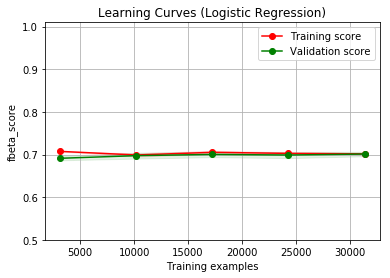

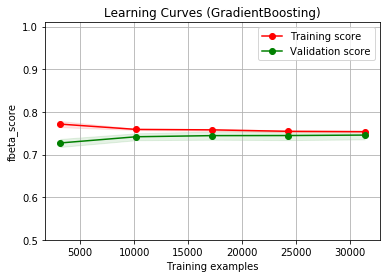

In [17]:
# 畫出學習曲線
title1 = "Learning Curves (Logistic Regression)"
title2 = "Learning Curves (GradientBoosting)"
cv = 5
tl.plot_learning_curve(Logreg, title1, features_raw_encode, income_raw_encode, ylim=(0.5, 1.01), cv=cv, n_jobs=1);
tl.plot_learning_curve(Grad, title2, features_raw_encode, income_raw_encode, ylim=(0.5, 1.01), cv=cv, n_jobs=1)

**結論:**
* 模型比較：
    -  GradientBoosting 的 F-beta score 較 LogisticRegression 高 4.4%，但 LogisticRegression 的訓練時間只要 0.37 秒，比 GradientBoosting 快 19 倍。
* 模型選擇：
    -  在這個專案中，沒有及時訓練及預測的需求，僅需定期優化模型與預測即可，因此優先考量的是準確預測以降低發送郵件的成本。接下來會選擇在初版模型中 F-beta score 較高的 GradientBoosting 進行優化而不是訓練速度較快的 Logistic Regression。
* 模型評估：
    -  學習曲線協助我們診斷模型過擬合。 當模型過擬合時，代表它在訓練集上表現良好，在驗證集上則不然。因此，該模型無法推廣到看不見的數據。如果模型過擬合，則學習曲線將顯示訓練和驗證分數之間的差距。過度擬合的兩種常見解決方案是降低模型的複雜性和/或收集更多數據。 另一方面，欠擬合意味著模型無法在訓練集或驗證集中表現良好。在這些情況下，學習曲線將收斂到低分值。當模型不合適時，收集更多數據沒有幫助，因為模型已經無法學習訓練數據。因此，這些情況的最佳方法是改進模型(例如調整參數)或改善數據的質量(例如收集不同的特徵集)。從圖中可以看出兩模型皆沒有過度擬合的問題，接著讓我來透過改善特徵與調整參數來獲得更好的準確度。

# 3. 改善資料質量

這節將透過探索性資料分析來找尋能夠改善資料質量的線索，例如特徵生成、特徵轉換等等，或者知道哪些特徵具有相同的資訊。然而，為了避免無止盡的探索，我將利用假設驅動(hypothesis driven approach)的方法進行：在一開始建立關於變量樣貌及其相關的假設，然後使用數據來證明（或反駁）這些假設。

## 3.1 探索性資料分析

In [18]:
df = data.copy()
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [19]:
df['income'] = df['income'].map({"<=50K":0,">50K":1})

**這次從對每個變數的假設出發:**
* age: 正常來說年齡與工作年資正相關，因此預期年齡越高收入也越高。
* workclass: 工作類型，預期跟收入有關，可觀察與年齡工時有沒有交互關係，例如高年齡的人在某種工作類型中，工時不高也有很好的收入。  
* education_level: 教育等級預期跟收入有正相關，教育等級收入也越高。
* eucation-num: 教育年數預期與收入有正相關，且跟教育等級(education_level)有關。
* marital-status: 婚姻狀態，預期與收入有關，俗話說先成家再立業。
* occupation:職業類別,預期不同職業類別與收入有關,可觀察與年齡,工時有沒有交互關係,例如高年齡的人在某種職業類別中,工時不高也有很好的收入。  
* relationship: 家庭角色，預期與收入有關。
* race: 人種，預期與膚色會影響收入。
* sex: 性別，預期男女收入不平等。
* capital-gain: 資本收益，收入的一部分，預期與收入呈正相關。
* capital-loss: 資本損失，預期與收入呈正相關。
* hours-per-week: 預期高工時會帶來高收入。
* native-country: 國籍，與人種(race)類似，預期與收入相關。

### 3.1.1 age

預期：年齡越高收入也越高。

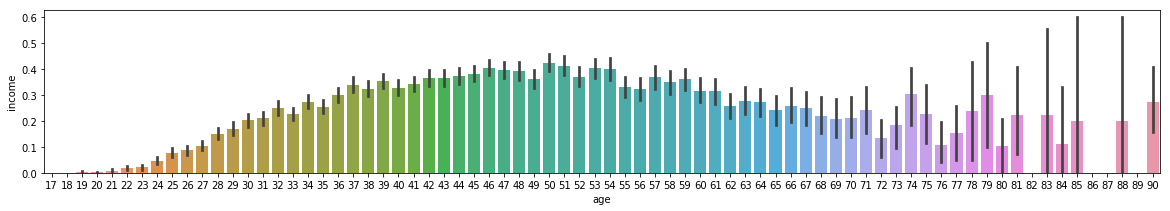

In [20]:
plt.figure(figsize=(20,3))
sns.barplot(df['age'],df['income']) #ci=None就會去掉標準差

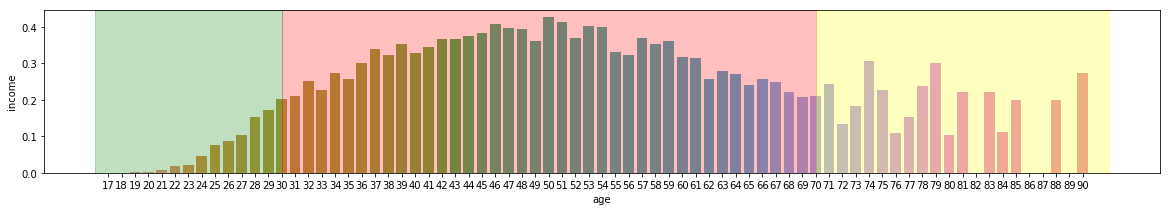

In [21]:
limit_1 = 30
limit_2 = 70

x_limit_1 = np.size(df[df['age'] < limit_1]['age'].unique())
x_limit_2 = np.size(df[df['age'] < limit_2]['age'].unique())

plt.figure(figsize=(20,3))
sns.barplot(df['age'],df['income'], ci=None)
plt.axvspan(-1, x_limit_1, alpha=0.25, color='green')
plt.axvspan(x_limit_1, x_limit_2, alpha=0.25, color='red')
plt.axvspan(x_limit_2, 75, alpha=0.25, color='yellow')

峰態與偏態

Skewness: 0.513322
Kurtosis: -0.173824


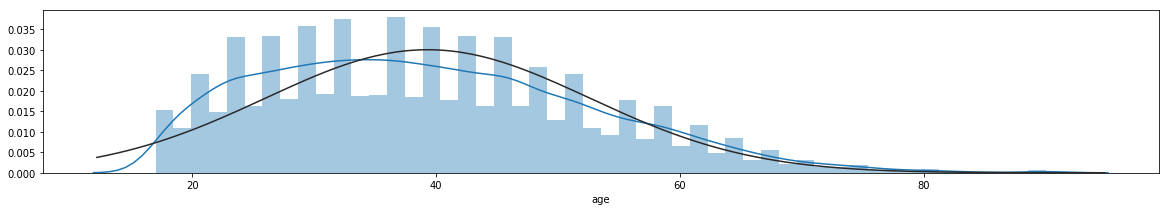

In [22]:
plt.figure(figsize=(20,3))
tl.distplot(df['age'])

- 可以看出年齡(age)於 50 歲時高收入的機率達到最高約為 40% ，而後緩慢遞減
- 70 歲以上高收入的機率下降，但因人數不多導致變異性很大<br\>

### 3.1.2 workclass

預期：跟收入有關

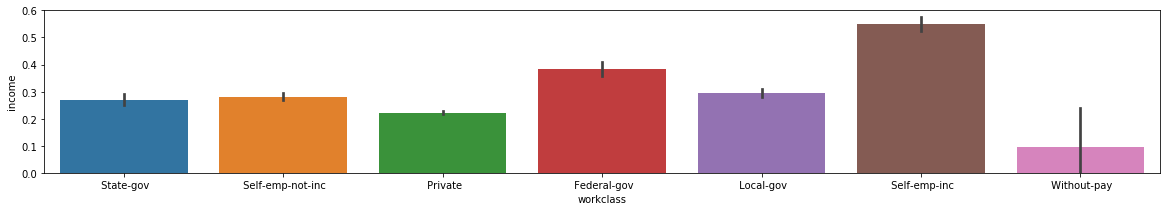

In [23]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['workclass'],df['income'])

數量分布

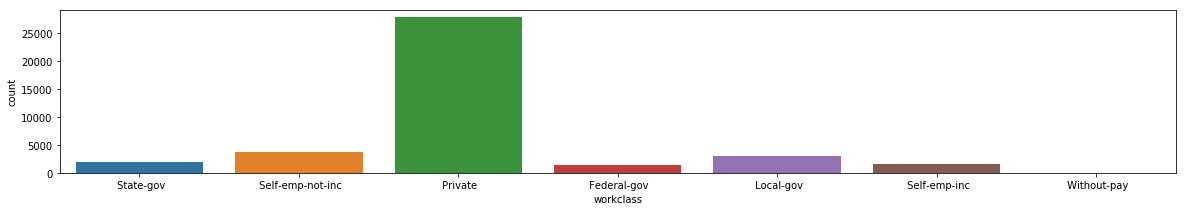

In [24]:
plt.figure(figsize=(20,3))
sns.countplot(x="workclass", data=df);

- 自我工作者及聯邦政府工作者高收入的機率最高，但數量不多
- 私人企業工作者超過半數

### 3.1.3 education_level

預期：跟收入有正相關

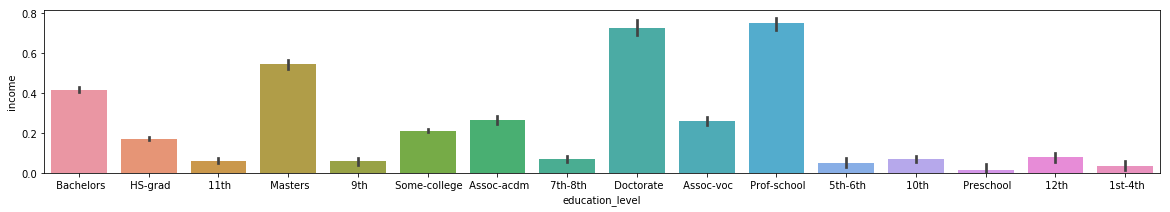

In [25]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['education_level'],df['income'])

### 3.1.4 education-num

預期：與收入有正相關

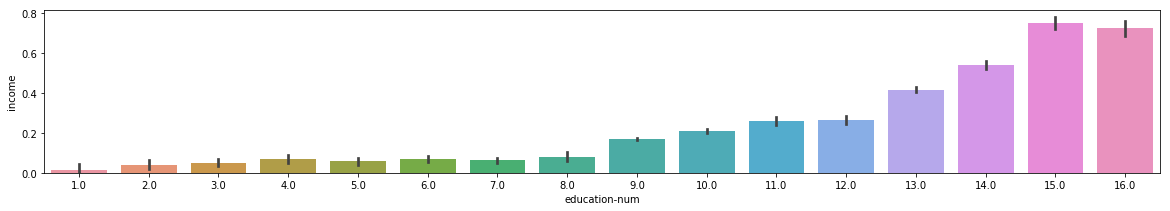

In [26]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['education-num'],df['income'])

峰態與偏態

Skewness: -0.357197
Kurtosis: 0.531310


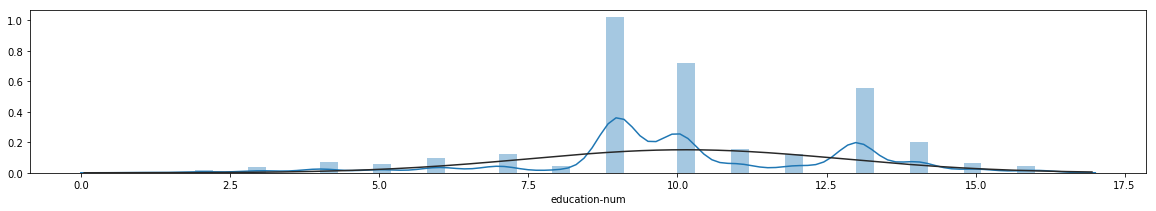

In [27]:
plt.figure(figsize=(20,3))
tl.distplot(df['education-num'])

In [28]:
df['education-num'].value_counts().head()

9.0     12003
10.0     8457
13.0     6522
14.0     2357
11.0     1859
Name: education-num, dtype: int64

In [29]:
df.groupby('education_level')['education-num'].agg([np.mean,np.size]).sort_values(by=['size'],ascending=False).head()

,mean,size
education_level,,
HS-grad,9.0,12003.0
Some-college,10.0,8457.0
Bachelors,13.0,6522.0
Masters,14.0,2357.0
Assoc-voc,11.0,1859.0


- 教育水準(education_level)和教育年數(education-num)具有相同資訊，資料類型不同而已,保留其一就好
- 樣本中以教育年數 9-10 年的人佔超過半數,再來是 13 年
- 和假設一致，教育年數(education-num)越高,高收入的機率就越高

### 3.1.5 marital-status

預期：與收入有關

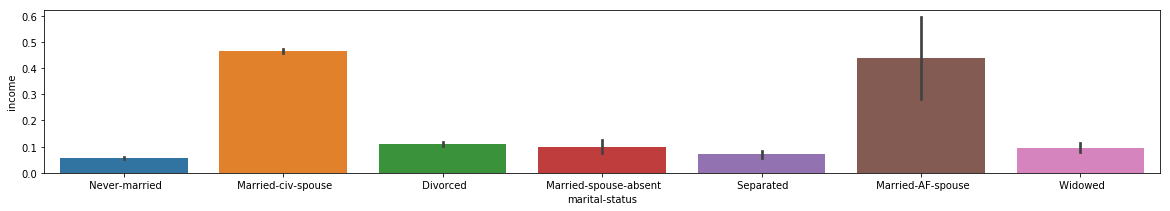

In [30]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['marital-status'],df['income'])

數量分布

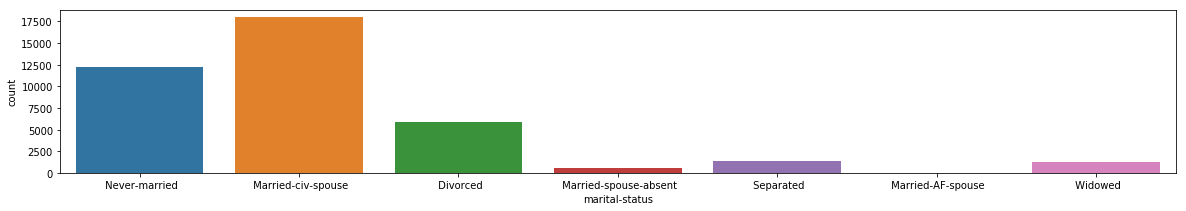

In [31]:
plt.figure(figsize=(20,3))
sns.countplot(x="marital-status", data=df);

- 'Married-civ-spouse'對收入具有良好的區隔性

### 3.1.6 occupation

預期：與收入有關

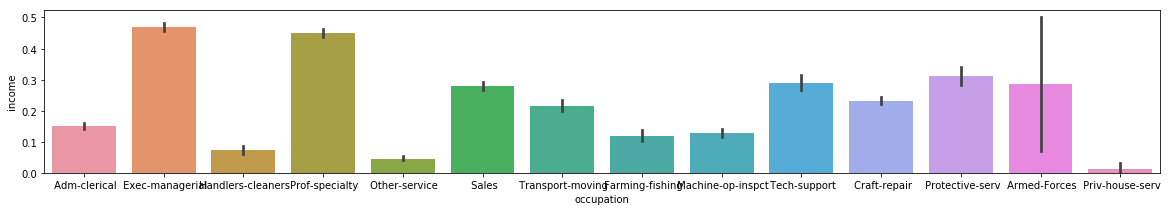

In [32]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['occupation'],df['income'])

數量分布

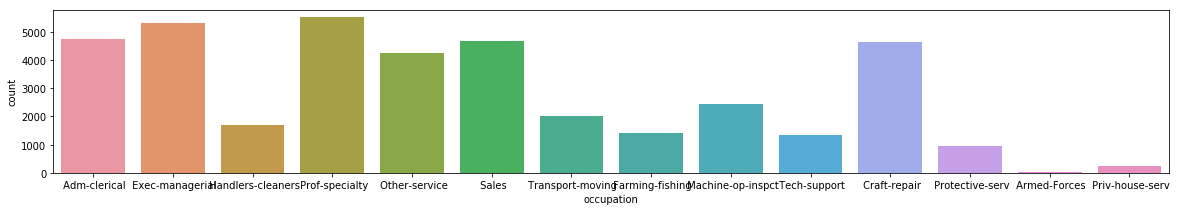

In [33]:
plt.figure(figsize=(20,3))
sns.countplot(x="occupation", data=df);

- 職業類別(occupation)對收入具有良好的區隔性
- 從事工藝修復(Craft-repair)、其他服務(Other-service)、業務(Sales)、執行管理(Exec-managerial)、教授(Prof-specialty)、文書(Adm-clerical)的人數較多
- 從事執行管理(Exec-managerial)及教授(Prof-specialty)較賺錢

### 3.1.7 relationship        

預期：與收入有關

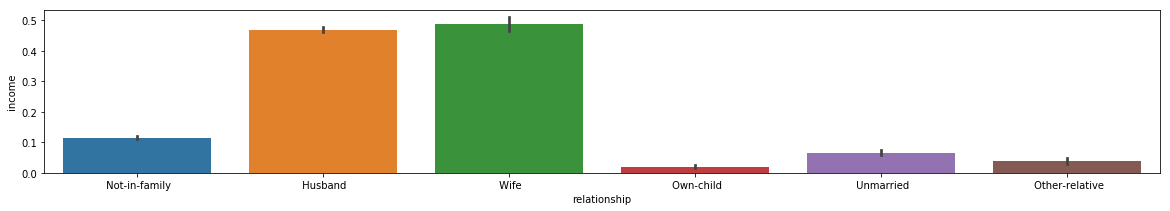

In [34]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['relationship'],df['income'])

數量分布

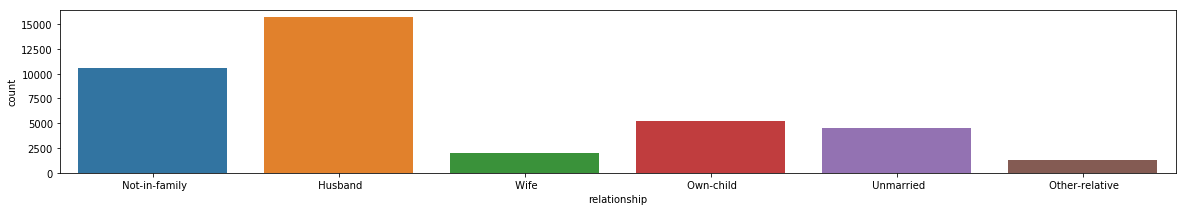

In [35]:
plt.figure(figsize=(20,3))
sns.countplot(x="relationship", data=df);

- 家庭角色(relationship)為丈夫或太太時高收入的可能性較高

### 3.1.8 race

預期：膚色會影響收入

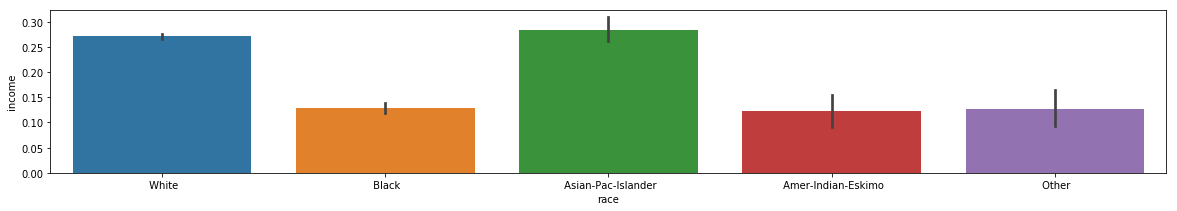

In [36]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='0')
sns.barplot(df['race'],df['income'])

數量分布

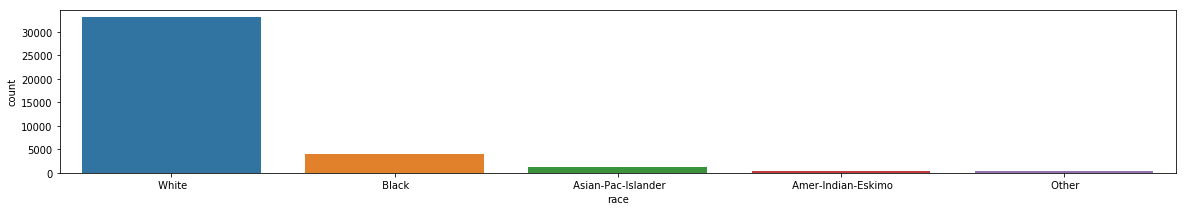

In [37]:
plt.figure(figsize=(20,3))
sns.countplot(x="race", data=df);

- 顯示亞太裔與白人高收入機率較高
- 過半數樣本皆是白人

### 3.1.9 sex

預期：男女收入不平等

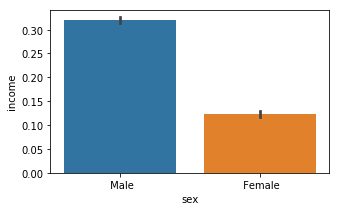

In [38]:
plt.figure(figsize=(5,3))
sns.barplot(df['sex'],df['income'])

數量分布

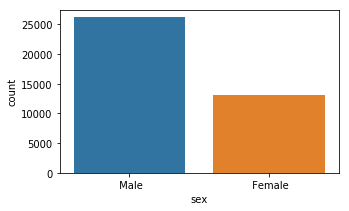

In [39]:
plt.figure(figsize=(5,3))
sns.countplot(x="sex", data=df);

- 男性高收入的機率明顯較高

### 3.1.10 capital-gain

預期：與收入呈正相關

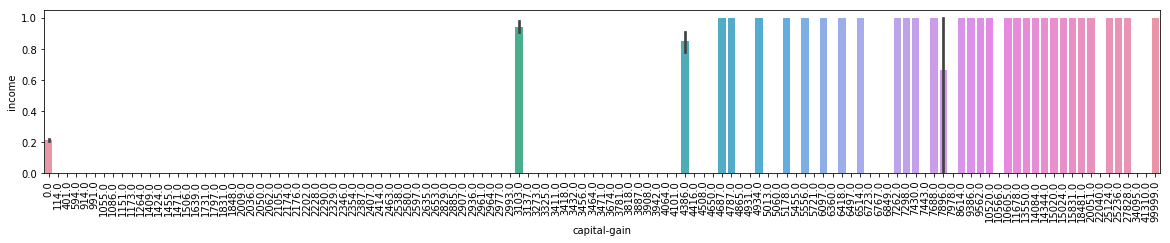

In [40]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='90')
sns.barplot(df['capital-gain'],df['income'])

峰態與偏態

Skewness: 11.045685
Kurtosis: 131.587750


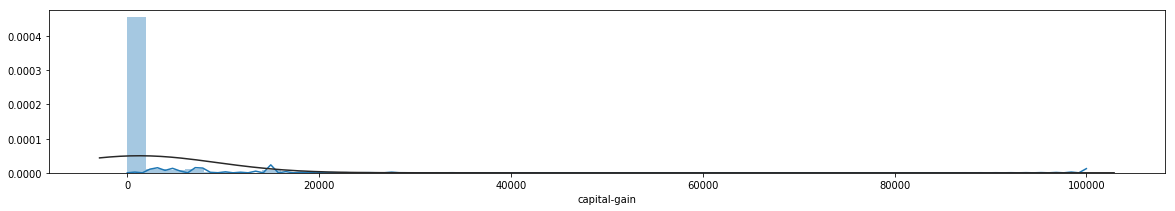

In [41]:
plt.figure(figsize=(20,3))
tl.distplot(df['capital-gain'])

- 對於偏態系數過高的變數資本收益(capital-gain)，若不進行轉換將影響線性模型的運作成效
- 從數量分布可以看出大多數人資本收益(capital-gain)為 0

### 3.1.11 capital-loss

預期：收入呈正相關

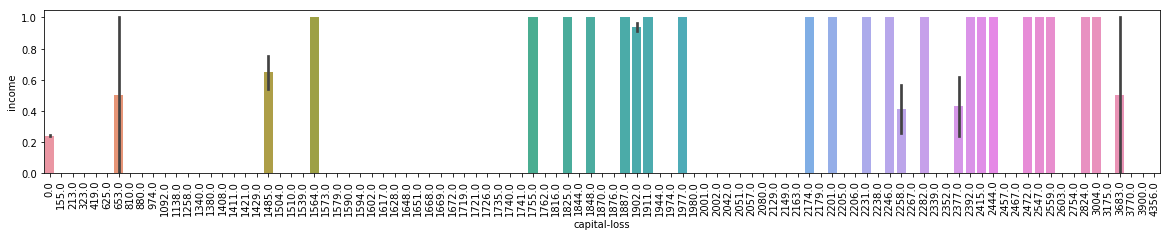

In [42]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='90')
sns.barplot(df['capital-loss'],df['income'])

峰態與偏態

Skewness: 4.181972
Kurtosis: 16.351477


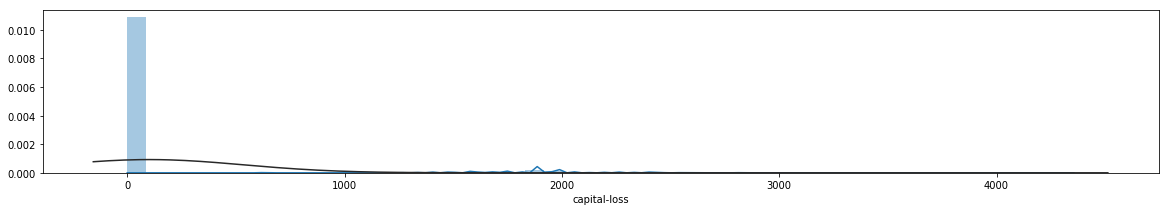

In [43]:
plt.figure(figsize=(20,3))
tl.distplot(df['capital-loss'])

- 同'capital-gain'

### 3.1.12 hours-per-week

預期：高工時會帶來高收入

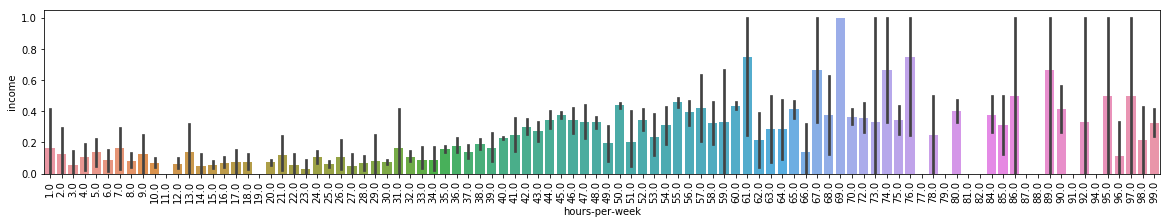

In [44]:
plt.figure(figsize=(20,3))
plt.xticks(rotation='90')
sns.barplot(df['hours-per-week'],df['income'])

峰態與偏態

Skewness: 0.358671
Kurtosis: 2.906215


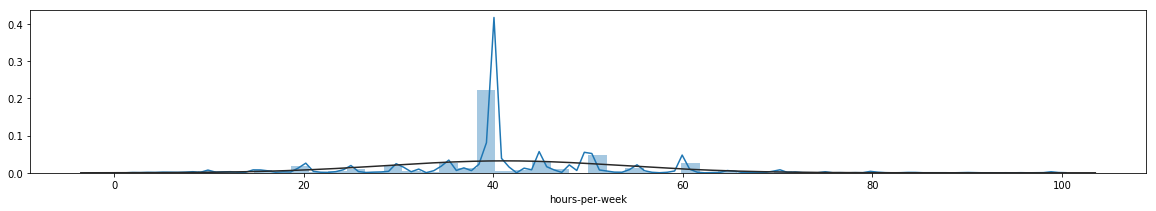

In [45]:
plt.figure(figsize=(20,3))
tl.distplot(df['hours-per-week'])

- 週工時(hours-per-week)從 1~70 左右與高收入的機率正相關,而後持平但標準差偏高
- 週工時(hours-per-week)= 40 佔整體數量約五成

### 3.1.13 native-country

預期：與收入相關

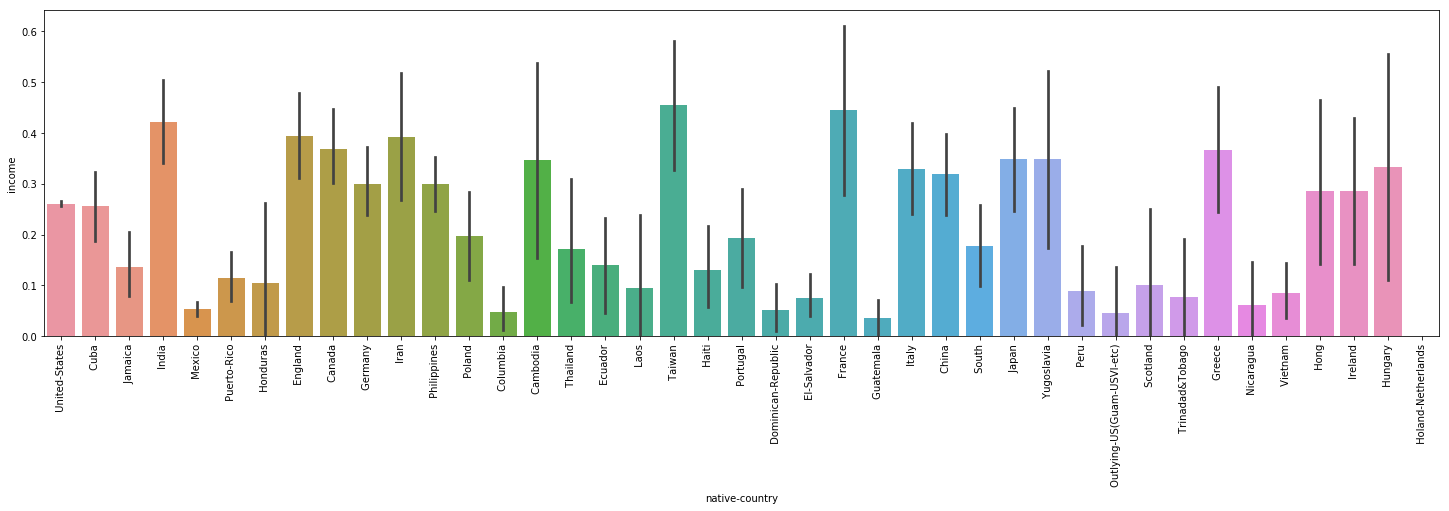

In [46]:
plt.subplots(figsize=(25, 6))
plt.xticks(rotation='90')
sns.barplot(df['native-country'],df['income'])

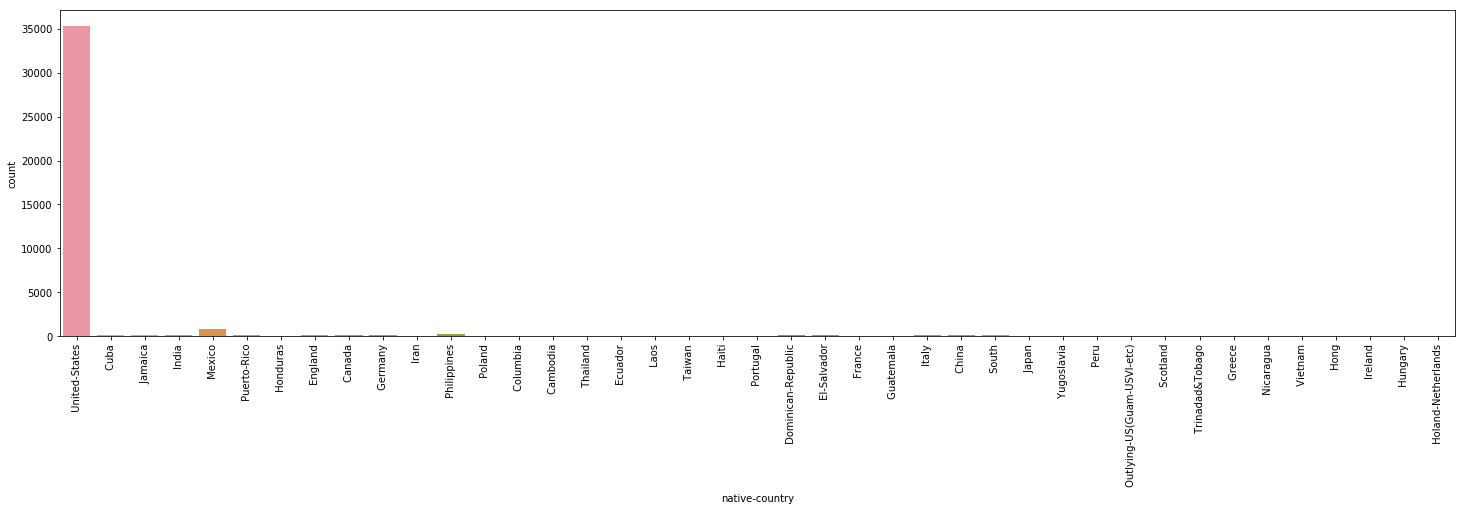

In [47]:
plt.subplots(figsize=(25, 6))
plt.xticks(rotation='90')
sns.countplot(x="native-country", data=df);

**針對以上探索,可得到結論：**
- 教育水準(education_level)和教育年數(education-num)具有相同資訊,資料類型不同而已,保留其一就好
- 資本收益(capital-gain)和資本損失(capital-loss)偏態系數較高，若有線性預測模型需進行特徵轉換
- 所有變數對收入皆具有區隔性，可加入模型進行預測

## 3.2 多變量分析

哪一種職業(occupation)在正常工時下最容易賺大錢呢?<br\>
- 執行管理(Exec-managerial)或者教授(Prof-specialty)。

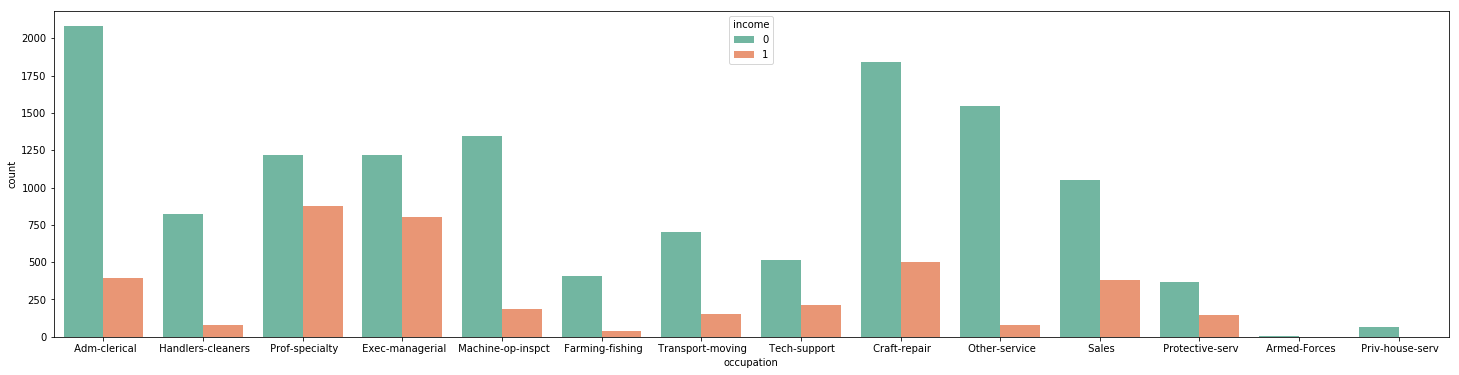

In [48]:
plt.subplots(figsize=(25, 6))
sns.countplot(x="occupation", hue="income", data=df[df['hours-per-week']==40],palette="Set2");

哪一種工作類型(workclass)最多大學畢業生賺大錢呢?<br\>
- 私人企業(Private)。但以比例來說，聯邦政府(Federal-gov)和自我工作者(Self-emp-inc)較高，前提是進得去。

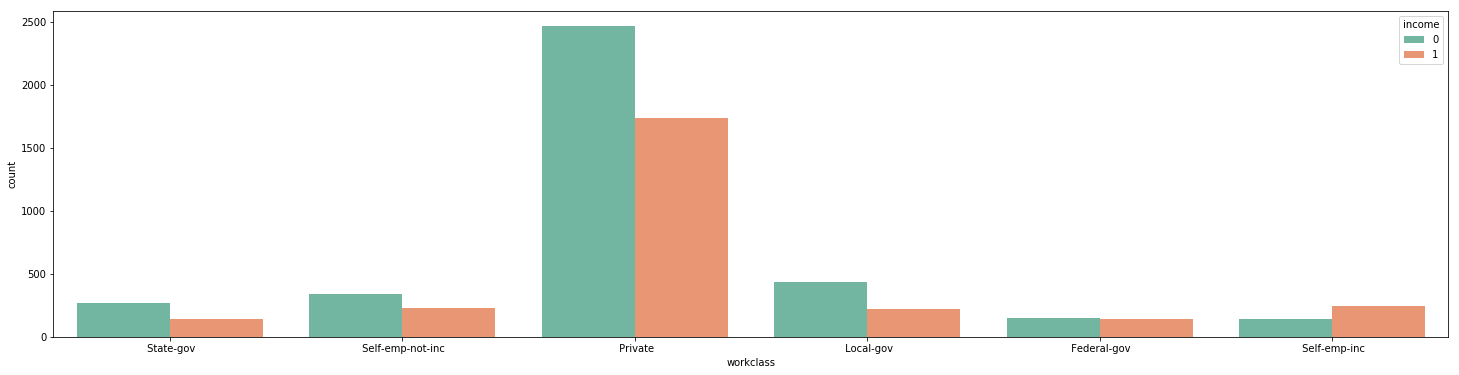

In [49]:
plt.subplots(figsize=(25, 6))
sns.countplot(x="workclass", hue="income", data=df[df["education-num"]==13],palette="Set2");

高中沒畢業的話要做哪一行(occupation)比較有機會賺大錢呢?<br\>
- 執行管理(Exec-managerial)或者運輸業(Transport-moving)。

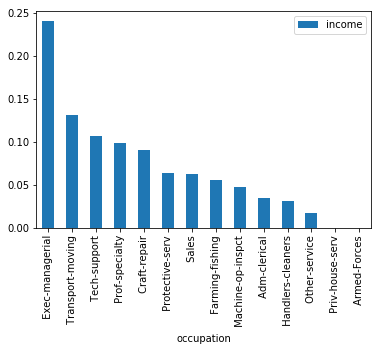

In [50]:
pd.DataFrame(df[df['education-num']<9].groupby(['occupation']).agg(np.mean).income.sort_values(ascending=False)).plot(kind='bar')

## 3.3 資料預處理

本小節將針對 3.1 節的資料探索結果進行資料的處理。然而，基於決策樹的模型只在乎特徵的順序，即使資本收益(capital-gain)和資本損失(capital-loss)偏態系數較高，進行特徵轉換對模型沒有幫助。此外，縮放特徵也是。因此，我將移除重複資訊的特徵、改變encoding的方式以降低特徵維度，預期能在不影響模型準確度的情況下加速訓練速度。

In [51]:
df = data.copy()

In [52]:
df = df.drop_duplicates()

In [53]:
# # 切分目標變數與預測變數
income_new = df['income']
features_new = df.drop('income', axis = 1)
# #移除重複資訊的特徵
features_new = features_new.drop(['education_level'], axis = 1)

In [54]:
#將類別特徵轉成數值特徵
income_new_encode = income_new.map({ "<=50K":0,">50K":1})
features_new_encode = features_new
features_cat = list(features_new_encode.columns[features_new_encode.dtypes=='object'])
le=LabelEncoder()
for i in features_cat:
    le.fit(features_new_encode[i])
    features_new_encode[i]=le.transform(features_new_encode[i])

## 3.4 資料評估

Training set has 31392 samples.
Testing set has 7848 samples.
GradientBoostingClassifier trained on 31392 samples
                  pred_time  train_time
GradientBoosting     0.1331      7.4514
GradientBoostingClassifier test mean scores = 0.7456280103805695 


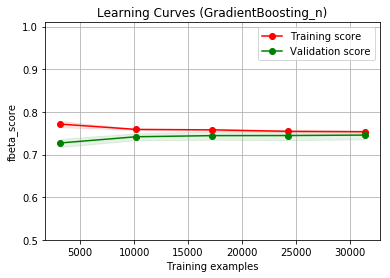

In [55]:
tl.features_evaluation(features_raw_encode, income_raw_encode)

Training set has 31392 samples.
Testing set has 7848 samples.
GradientBoostingClassifier trained on 31392 samples
                  pred_time  train_time
GradientBoosting     0.0469      1.2886
GradientBoostingClassifier test mean scores = 0.7444746125029131 


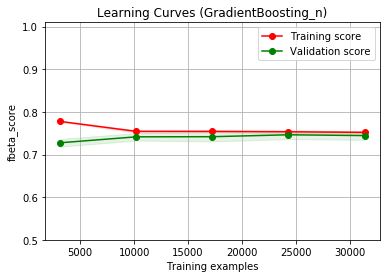

In [56]:
tl.features_evaluation(features_new_encode, income_new_encode)

**結論:**
- 本節透過探索性資料分析發現教育水準(education_level)和教育年數(education-num)具有相同資訊
- 資本收益(capital-gain)和資本損失(capital-loss)偏態系數較高
- 透過本節的預處理，可在維持預測準確度(-0.1%)的同時降低 80% 模型訓練速度 

# 4. 模型優化

本節將透過 GridSearch 對 GradientBoosting 進行參數調整，接著比較調整前後的分數，最後確定哪些特徵提供最多預測能力。

## 4.1 GradientBoosting 參數調整

要調節的參數有兩種：樹參數和 boosting 參數。當決策樹數量夠多時，較小的 learning rate 總是較好，但是若一味地減小 learning rate、增加樹，就需要很長的模型訓練時間。因此我們將 learning rate 留到最後再調整。基本流程如下：
1.  **選擇一個相對來説稍微高一點的 learning rate**。一般默認是 0.1，不過針對不同的問題，0.05 到 0.2 之間都可以。
2.  **決定目前 learning rate 下最優的決策樹數量**。它的值應該在 40-70 之間。樹越多則訓練越久。
3.  接着**調整樹參數**。選擇不同的參數來定義一個決策樹。
4.  **降低 learning rate ，同時增加相應的決策樹數量**使模型更穩健。

### 4.1.1 調整 n_estimators

n_ estimators 定義需要使用到的決定樹的數量，雖然 GradientBoosting 即使在有較多決定樹時仍然能保持穩健，但還是可能發生過度擬合。

In [57]:
scorer = make_scorer(fbeta_score, beta=0.5)

In [58]:
learning_rate = 0.2

In [59]:
# 決定目前 learning rate下的樹數量(n_estimators)
param_test1 = {'n_estimators':range(70,161,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,random_state=0), 
                                    param_grid = param_test1, scoring=scorer,n_jobs=1,iid=False, cv=5)
gsearch1.fit(features_new_encode,income_new_encode)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'n_estimators': range(70, 161, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [60]:
pd.DataFrame(gsearch1.cv_results_).loc[:,['params','mean_test_score']]

,params,mean_test_score
0,{'n_estimators': 70},0.749068
1,{'n_estimators': 80},0.751010
2,{'n_estimators': 90},0.752157
3,{'n_estimators': 100},0.753635
4,{'n_estimators': 110},0.753071
5,{'n_estimators': 120},0.753554
6,{'n_estimators': 130},0.754571
7,{'n_estimators': 140},0.754667
8,{'n_estimators': 150},0.754024
9,{'n_estimators': 160},0.753728


In [61]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 140}, 0.7546667526873932)

### 4.1.2 調整 max_depth 和 min_samples_split

max_ depth 定義樹的最大深度，越深就越可能過擬合。<br\>
min_samples_split 定義樹中一個節點所需要用來分裂的最少樣本數，可以避免過擬合。

In [62]:
learning_rate = 0.2
n_estimators= 140

In [63]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_features='sqrt', subsample=0.8, random_state=0), 
param_grid = param_test2, scoring=scorer,n_jobs=1,iid=False, cv=5)
gsearch2.fit(features_new_encode,income_new_encode)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [64]:
pd.DataFrame(gsearch2.cv_results_).loc[:,['params','mean_test_score']]

,params,mean_test_score
0,"{'max_depth': 5, 'min_samples_split': 200}",0.747861
1,"{'max_depth': 5, 'min_samples_split': 400}",0.750624
2,"{'max_depth': 5, 'min_samples_split': 600}",0.748249
3,"{'max_depth': 5, 'min_samples_split': 800}",0.750651
4,"{'max_depth': 5, 'min_samples_split': 1000}",0.748342
5,"{'max_depth': 7, 'min_samples_split': 200}",0.741799
6,"{'max_depth': 7, 'min_samples_split': 400}",0.746161
7,"{'max_depth': 7, 'min_samples_split': 600}",0.747211
8,"{'max_depth': 7, 'min_samples_split': 800}",0.746392
9,"{'max_depth': 7, 'min_samples_split': 1000}",0.748642


In [65]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_samples_split': 800}, 0.7506512981897118)

### 4.1.3 調整 min_samples_leaf

min_ samples_leaf 定義樹中終點節點所需要的最少的樣本數，在不均分類問題中，這個參數需要被設定為較小的值，因為大部分少數類別含有的樣本都比較小。

In [66]:
learning_rate = 0.2
n_estimators= 140
max_depth=5
min_samples_split=800

In [67]:
param_test3 = {'min_samples_leaf':range(10,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,min_samples_split=min_samples_split, n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt', subsample=0.8, random_state=0), 
param_grid = param_test3, scoring=scorer,n_jobs=1,iid=False, cv=5)
gsearch3.fit(features_new_encode,income_new_encode)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'min_samples_leaf': range(10, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [68]:
pd.DataFrame(gsearch3.cv_results_).loc[:,['params','mean_test_score']]

,params,mean_test_score
0,{'min_samples_leaf': 10},0.750230
1,{'min_samples_leaf': 20},0.751349
2,{'min_samples_leaf': 30},0.750508
3,{'min_samples_leaf': 40},0.749681
4,{'min_samples_leaf': 50},0.749289
5,{'min_samples_leaf': 60},0.747555
6,{'min_samples_leaf': 70},0.748526


In [69]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 20}, 0.7513488429752474)

### 4.1.4 調整 max_features

max_ features 決定用於分類的特徵數，是人為隨機定義的。過多的分類特徵可能也會導致過度擬合。

In [70]:
learning_rate = 0.2
n_estimators= 140
max_depth=5
min_samples_split=800
min_samples_leaf=20

In [71]:
param_test4 = {'max_features':range(6,12)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, n_estimators=n_estimators,max_depth=max_depth, subsample=0.8, random_state=0), 
param_grid = param_test4, scoring=scorer,n_jobs=1,iid=False, cv=5)
gsearch4.fit(features_new_encode,income_new_encode)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samp...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_features': range(6, 12)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [72]:
pd.DataFrame(gsearch4.cv_results_).loc[:,['params','mean_test_score']]

,params,mean_test_score
0,{'max_features': 6},0.750669
1,{'max_features': 7},0.751084
2,{'max_features': 8},0.748772
3,{'max_features': 9},0.749924
4,{'max_features': 10},0.748963
5,{'max_features': 11},0.750819


In [73]:
gsearch4.best_params_, gsearch4.best_score_ 

({'max_features': 7}, 0.7510839184619323)

### 4.1.5 調整子樣本比例來降低 learning rate

subsample 決定訓練每個決策樹所用到的子樣本佔總樣本的比例

In [74]:
learning_rate = 0.2
n_estimators= 140
max_depth=5
min_samples_split=800
min_samples_leaf=20
max_features=7

In [75]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,min_samples_split=min_samples_split,max_features=max_features,min_samples_leaf=min_samples_leaf, n_estimators=n_estimators,max_depth=max_depth, random_state=0), 
param_grid = param_test5, scoring=scorer,n_jobs=1,iid=False, cv=5)
gsearch5.fit(features_new_encode,income_new_encode)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=5,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=0)

In [76]:
pd.DataFrame(gsearch5.cv_results_).loc[:,['params','mean_test_score']]

,params,mean_test_score
0,{'subsample': 0.6},0.748043
1,{'subsample': 0.7},0.746995
2,{'subsample': 0.75},0.748475
3,{'subsample': 0.8},0.751084
4,{'subsample': 0.85},0.749260
5,{'subsample': 0.9},0.748614


In [77]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.7510839184619323)

### 4.1.6 增加 n_estimators，降低 learning rate

In [78]:
learning_rate = 0.2
n_estimators= 140
max_depth=5
min_samples_split=800
min_samples_leaf=20
max_features=7
subsample= 0.8


Model Report
F-beta score (Train): 0.7712
AUC Score (Train): 0.935486
CV Score : Mean - 0.7510839 | Std - 0.0083682 | Min - 0.7410582 | Max - 0.7663854


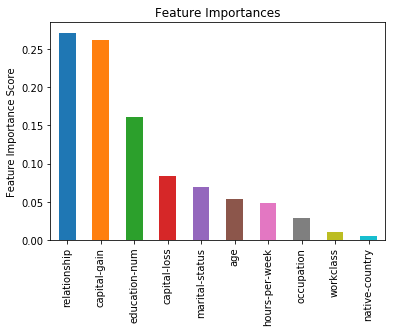

In [79]:
gb_tuned_1 = GradientBoostingClassifier(learning_rate=learning_rate,min_samples_split=min_samples_split,max_features=max_features,min_samples_leaf=min_samples_leaf,subsample=subsample, n_estimators=n_estimators,max_depth=max_depth, random_state=0)
tl.modelfit(gb_tuned_1, features_new_encode,income_new_encode) 

In [80]:
learning_rate = 0.1
n_estimators=280


Model Report
F-beta score (Train): 0.77
AUC Score (Train): 0.935105
CV Score : Mean - 0.7516993 | Std - 0.008493577 | Min - 0.7401779 | Max - 0.7666317


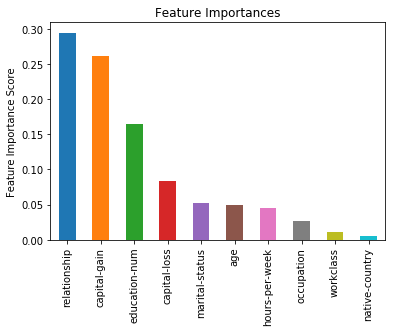

In [81]:
gb_tuned_2 = GradientBoostingClassifier(learning_rate=learning_rate,min_samples_split=min_samples_split,max_features=max_features,min_samples_leaf=min_samples_leaf,subsample=subsample, n_estimators=n_estimators,max_depth=max_depth, random_state=0)
tl.modelfit(gb_tuned_2, features_new_encode,income_new_encode) 

## 4.2 模型評估

- 可以看出調整參數之後的模型可以學習到更複雜、更擬合訓練資料的結果，但對驗證資料準確度提昇不大 0.7%。

## 4.3 特徵重要性

除了預測哪些人具有高收入外，另外一個重要的課題是：哪些特徵最具預測能力?這些具有預測能力的特徵會成為往後解決類似問題時資料收集的方向，或者透過較少的特徵就能獲得準確的預測結果。

**前五重要的特徵**
* 資本收益和資本損失：資本也應與收入密切相關。
* 教育年數：教育程度越高越容易取得高薪工作。
* 婚姻狀態_已婚：這是讓我比較意外的特徵，但顯然已婚對高收入具有相當的重要性，甚至超過年齡。
* 家庭角色_丈夫：這個特徵可以視為已婚與男性的綜合體，如先前的分析已知男性對高收入有明顯的影響。

# 5. 結論

本文利用 DeepLearning (2016)書中建議的方法走過機器學習的流程，從快速建立一個簡單的模型 pipeline 開始，藉由評估模型(F-beta score)了解優化方向，接著由探索性分析與特徵工程改善特徵(降低模型訓練速度 80%)，最後優化模型參數獲得更佳的準確率(提升驗證集 F-beta score 0.7%)。這個方法能夠透過反覆快速驗證(嘗試錯誤)來確認每一步的改變是否正確，漸進式提高性能並得到近似上限的結果。在特徵重要性中，資本收益和資本損失是決定模型判斷是否為高收入者的主要特徵，其次是教育程度及婚姻狀態。

# 6. 參考資料

- [Deeplearning(Ian Goodfellow and Yoshua Bengio and Aaron Courville)](https://www.deeplearningbook.org/)

- [Pedro Marcelino](http://pmarcelino.com/)

- [Seaborn](https://seaborn.pydata.org/)

- [Learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)

- [Python中Gradient Boosting Machine(GBM）調參方法詳解](https://hk.saowen.com/a/1c3a2461cd3507b93cf3708282e0479cc9b44f3a8bc6681451f7719befe9ee57)